In [106]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models, layers


In [ ]:

data_dir = r'/Users/saktiyoga/Development/PMDPM/train_data'

def load_data(data_dir, img_size=(224, 224), batch_size=32, augment=False):
    if augment:
        data_gen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
        )
    else:
        data_gen = ImageDataGenerator(rescale=1./255)

    dataset = data_gen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    return dataset

train_data = load_data(os.path.join(data_dir), augment=True)
val_data = load_data(os.path.join(data_dir))


Found 301 images belonging to 3 classes.


Found 301 images belonging to 3 classes.


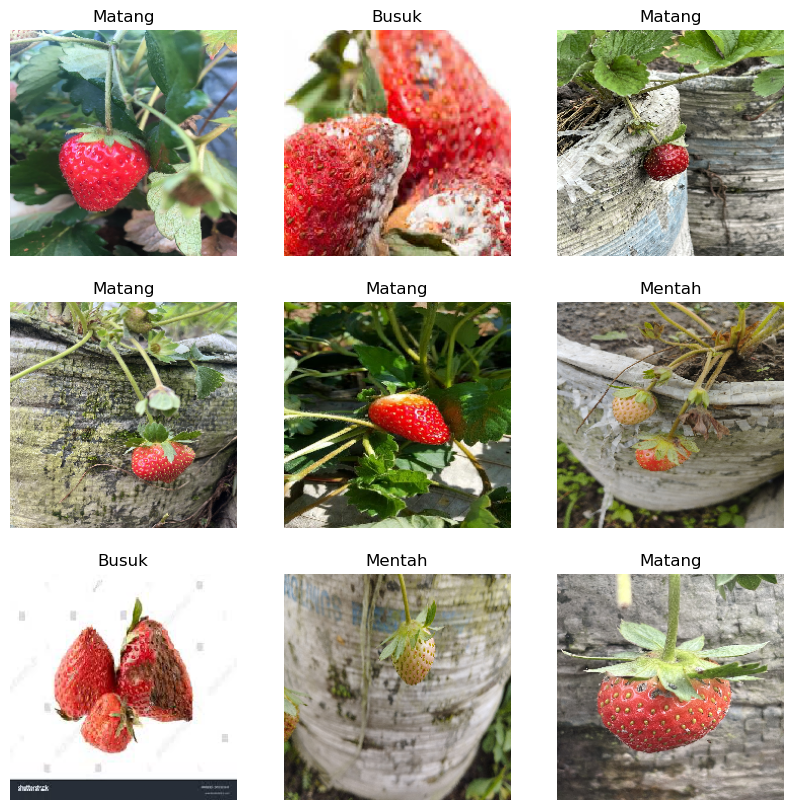

In [ ]:
def visualize_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    images, labels = [], []
    
    for batch_images, batch_labels in dataset:
        images.extend(batch_images)
        labels.extend(batch_labels)
        if len(images) >= num_images:
            break

    images = np.array(images[:num_images])
    labels = np.array(labels[:num_images])
    
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(list(dataset.class_indices.keys())[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()


visualize_images(train_data_example)

In [ ]:
def prepare_data(data_dir, img_size=(224, 224), batch_size=32):
    train_dir = os.path.join(data_dir)
    val_dir = os.path.join(data_dir)
    test_dir = os.path.join('/Users/saktiyoga/Development/PMDPM/test_data')

    train_data = load_data(train_dir, img_size, batch_size)
    val_data = load_data(val_dir, img_size, batch_size)
    test_data = load_data(test_dir, img_size, batch_size)

    print(f"Train data size: {train_data.samples}")
    print(f"Validation data size: {val_data.samples}")
    print(f"Test data size: {test_data.samples}")

    return train_data, val_data, test_data

data_dir = r'/Users/saktiyoga/Development/PMDPM/train_data'
train_data, val_data, test_data = prepare_data(data_dir)

Found 301 images belonging to 3 classes.
Found 301 images belonging to 3 classes.
Found 301 images belonging to 3 classes.
Train data size: 301
Validation data size: 301
Test data size: 301


In [ ]:
def create_model(input_shape=(224, 224, 3), num_classes=3):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, 
                                                   include_top=False, 
                                                   weights=None)

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    model.summary()
    return model

model = create_model()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 2,227,715 (8.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [113]:
from tensorflow.keras.callbacks import EarlyStopping

def train_model(model, train_data, val_data, epochs=20):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(train_data, 
                        validation_data=val_data, 
                        epochs=epochs, 
                        callbacks=[early_stopping])
    return history

history = train_model(model, train_data, val_data, epochs=20)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.6752 - loss: 0.8182 - val_accuracy: 0.3355 - val_loss: 1.0988
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.7641 - loss: 0.5618 - val_accuracy: 0.3322 - val_loss: 1.0987
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.8241 - loss: 0.3878 - val_accuracy: 0.3322 - val_loss: 1.0987
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.9352 - loss: 0.1967 - val_accuracy: 0.3322 - val_loss: 1.0996
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.9479 - loss: 0.1539 - val_accuracy: 0.3322 - val_loss: 1.1026
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.9825 - loss: 0.0700 - val_accuracy: 0.3322 - val_loss: 1.1044
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.9610 - loss: 0.0807 - val_accuracy: 0.3322 - val_loss: 1.1163
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 78s 8s/step - accuracy: 0.9251 - loss: 0.1287 - val_accuracy: 0.3322 - val_loss:

10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step


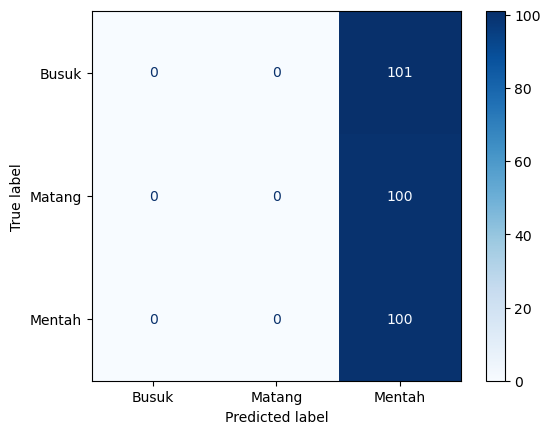

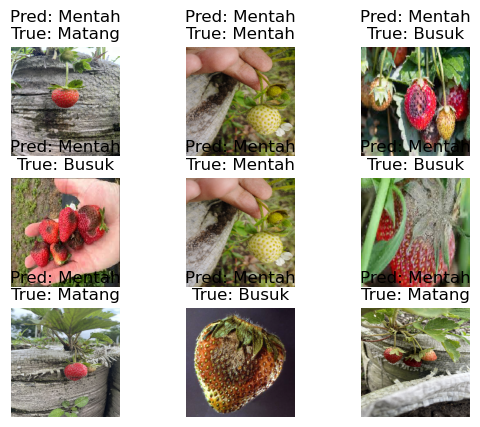

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, test_data):
    predictions = model.predict(test_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_data.classes

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=list(test_data.class_indices.keys()))
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    test_data.reset()  
    images, labels = next(test_data)
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        pred_label = list(test_data.class_indices.keys())[np.argmax(predictions[i])]
        true_label = list(test_data.class_indices.keys())[np.argmax(labels[i])]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
        plt.axis('off')
    plt.show()


evaluate_model(model, test_data)

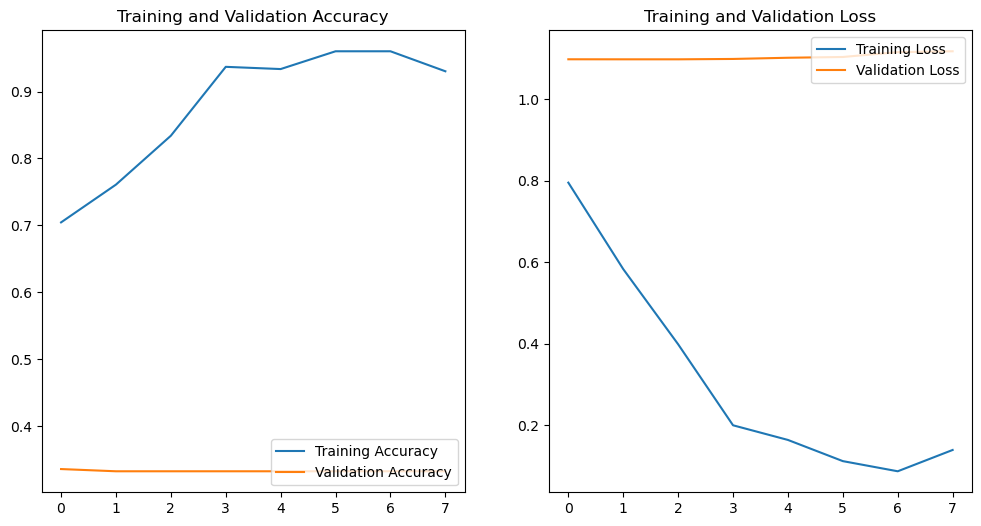

In [ ]:
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_metrics(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Predicted Strawberry Condition: busuk


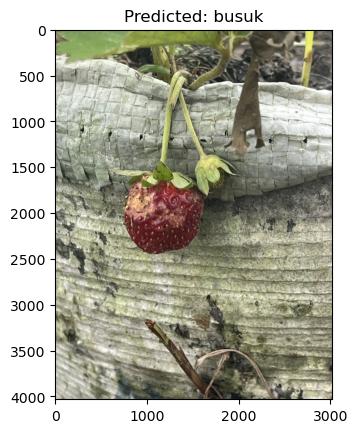

In [ ]:

def predict_strawberry(image_path, model):
    
    img = tf.keras.preprocessing.image.load_img(
        image_path, 
        target_size=(224, 224)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) / 255.0
    
 
    predictions = model.predict(img_array)
    predicted_class = categories[np.argmax(predictions[0])]
    
    print(f'Predicted Strawberry Condition: {predicted_class}')
    plt.imshow(plt.imread(image_path))
    plt.title(f'Predicted: {predicted_class}')
    plt.show()


predict_strawberry('/Users/saktiyoga/Development/PMDPM/test_data/Busuk/busuk_07.jpg', model)
